---
title: Results
format:
  html:
    code-fold: true
output-file: results.html
---

In [1]:
#| hide
%load_ext autoreload
%autoreload 2

## Setup

### Import libraries

In [2]:
from fastcore.utils import *
from fastcore.test import *

from ids_finder.utils import *
from ids_finder.core import pl_norm

from datetime import timedelta

import polars as pl
import polars.selectors as cs
import pandas as pd
import numpy as np

import seaborn as sns
import altair as alt
import vegafusion as vf
vf.enable(row_limit = int(1e6))

vegafusion.enable(mimetype='html', row_limit=1000000, embed_options=None)

#### Connect `python` with `R` kernel

In [3]:
%load_ext rpy2.ipython
from ids_finder.utils.r import py2rpy_polars

conv_pl = py2rpy_polars()

In [4]:
%%R
library(ggplot2)
library(ggpubr)
library(viridis)

library(glue)
library(arrow)

Loading required package: viridisLite


#### `Kedro`

In [47]:
from ids_finder.utils.basic import load_catalog

catalog = load_catalog()
catalog.list()

[10/16/23 10:21:18] WARNING  KedroDeprecationWarning: 'ParquetDataSet' has been renamed to            ]8;id=308973;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=901761;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             'ParquetDataset', and the alias will be removed in Kedro-Datasets 2.0.0               
                                                                                                                   

                    WARNING  FutureWarning: Defining the 'layer' attribute at the top level is        ]8;id=958556;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=99064;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             deprecated and will be removed in Kedro 0.19.0. Please move 'layer'                   
                             inside the 'metadata' -> 'kedro-viz' attributes. See                                  
                             https://docs.kedro.org/en/latest/visualisation/kedro-viz_visualisation.h              
                             tml#visualise-layers for more information.                                            
                                                                                                                   

                    WARNING  KedroDeprecationWarning: 'CSVDataSet' has been renamed to 'CSVDataset',  ]8;id=839096;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=701209;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             and the alias will be removed in Kedro-Datasets 2.0.0                                 
                                                                                                                   

                    WARNING  KedroDeprecationWarning: 'GenericDataSet' has been renamed to            ]8;id=423976;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=499879;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             'GenericDataset', and the alias will be removed in Kedro-Datasets 2.0.0               
                                                                                                                   


[
    'JNO_index',
    'jno.raw_jno_ss_se_1sec',
    'jno.inter_jno_ss_se_1s',
    'jno.raw_state',
    'model.raw_jno_ss_se_1min',
    'model.preprocessed_jno_ss_se_1min',
    'candidates_all_1s',
    'sta.raw_sta_state',
    'parameters',
    'params:tau',
    'params:jno_start_date',
    'params:jno_end_date',
    'params:jno_1s_params',
    'params:jno_1s_params.bcols',
    'params:jno_1s_params.data_resolution',
    'params:jno.extract_params',
    'params:jno.extract_params.bcols',
    'params:jno.extract_params.data_resolution',
    'params:sta.extract_params',
    'params:sta.extract_params.bcols',
    'params:sta.extract_params.data_resolution'
]

In [56]:
import matplotlib.pyplot as plt
import scienceplots
from ids_finder.utils.basic import savefig

plt.style.use(['science', 'nature', 'notebook'])


## Setup

### Read all candidates from different sources

In [6]:
candidates_sta_tau_60s : pl.DataFrame = catalog.load('candidates.sta_tau_60s')
candidates_jno_tau_60s : pl.DataFrame = catalog.load('candidates.jno_tau_60s')
candidates_thb_tau_60s : pl.DataFrame = catalog.load('candidates.thb_tau_60s')

                    INFO     Loading data from 'candidates.sta_tau_60s' (GenericDataset)...     ]8;id=326447;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=8447;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'candidates.jno_tau_60s' (GenericDataset)...     ]8;id=111424;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=331807;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'candidates.thb_tau_60s' (GenericDataset)...     ]8;id=101522;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=597309;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [15]:
if Path("../data/candidates.csv").exists():
    all_candidates = pl.read_csv("../data/candidates.csv")
else:
    all_candidates = pl.concat(
    [
        candidates_jno_tau_60s.with_columns(sat=pl.lit("JNO")).with_columns(pl.col('sw_temperature').cast(pl.Float64)),
        candidates_thb_tau_60s.with_columns(sat=pl.lit("THB")),
        candidates_sta_tau_60s.with_columns(sat=pl.lit("STA")).with_columns(pl.selectors.float().cast(pl.Float64)),
    ],
    how="diagonal"
)
    # all_candidates.write_csv()

In [22]:
from astropy import constants as const
au_in_km = const.au.to("km").value

jno_dist_cols = ["X", "Y", "Z"]

candidates_jno_tau_60s = candidates_jno_tau_60s.with_columns(
    pl_norm(jno_dist_cols).alias("distance"),
).with_columns(
    (pl.col(["X", "distance"]) / au_in_km).map_alias(lambda col: col+"_in_AU"),
).sort("time")

jno_candidates_filtered = candidates_jno_tau_60s.filter(
        pl.col("time") < pd.Timestamp("2016-05-01") # There is a sudden increase in the number of TD candidates after this date
)

In [ ]:
%R -i jno_candidates -c conv_pl
%R -i thb_candidates -c conv_pl
%R -i sta_candidates -c conv_pl
%R -i jno_candidates_filtered -c conv_pl

## Profiling

In [ ]:
from ydata_profiling import ProfileReport

In [ ]:
candidates_jno_tau_60s.columns

In [ ]:
df = candidates_jno_tau_60s.select(["time", 'index_diff', "B", 'B_n', 'BnOverB', 'dB', 'dBOverB', 'rotation_angle', 'type', "X"]).to_pandas()

In [ ]:
profile = ProfileReport(df, title="JUNO Candidates Report")
profile.to_file("jno.html")

In [ ]:
from functools import reduce

@patch
def sel(self: pl.LazyFrame | pl.DataFrame, **kwargs):
    predicates = []
    for k, v in kwargs.items():
        if isinstance(v, slice):
            predicate = pl.col(k).is_between(v.start, v.stop)
        else:
            predicate = pl.col(k) == v
        predicates.append(predicate)
    
    return self.filter(reduce(operator.and_, predicates))

## Analysis

In [38]:
def normalize_count(
    count_df: pl.DataFrame | pl.LazyFrame,  # the dataframe with count to be normalized
    data: pl.DataFrame | pl.LazyFrame,  # the data used to calculate the duration ratio
    s_resolution,
    l_resolution,
):
    duration_df = (
        data.lazy().sort("time")
        .group_by_dynamic("time", every=s_resolution)
        .agg(pl.lit(1).alias("availablity"))
        .group_by_dynamic("time", every=l_resolution)
        .agg(
            (pl.sum("availablity") * s_resolution / l_resolution).alias(
                "duration_ratio"
            )
        )
    )

    count_normalized_df = (
        count_df.lazy()
        .join(duration_df, left_on="truncated_time", right_on="time", how="left")
        .with_columns((pl.col("count") / pl.col("duration_ratio")).alias("count"))
    )

    return count_normalized_df.collect()

### Thickness, current intensity

Notes: candidates may contain `nan` values because of the possibility of missing data of state datasets.

In [ ]:
candidates_sta_1s = catalog.load('candidates.sta_1s')
candidates_jno_1s = catalog.load('candidates.jno_1s')


                    INFO     Loading data from 'candidates.sta_1s' (GenericDataSet)...          ]8;id=373604;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=562664;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

                    INFO     Loading data from 'candidates.jno_1s' (GenericDataSet)...          ]8;id=444289;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=837905;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [ ]:
from fastcore.utils import patch
from pipe import select

@patch
def plot(self:pl.DataFrame, *args, **kwargs):
    return self.to_pandas().plot(*args, **kwargs)

@patch
def hvplot(self:pl.DataFrame, *args, **kwargs):
    return self.to_pandas().hvplot(*args, **kwargs)

In [ ]:
vars = ["sw_vel_mn", "L_mn", "L_mn_norm", "j0"]


def cplot(df):
    return df.plot(x="time", y=vars, subplots=True, logy=True)


def cplot_r(df):
    return df.plot(x="radial_distance", y=vars, subplots=True, logy=True)


def get_dfs(df: pl.DataFrame):
    df = df.sort("time").filter(pl.all_horizontal(cs.by_name(vars).is_not_nan()))
    every = "10d"
    avg_df = (
        # df.filter(pl.col("d_star") < 100)
        df.group_by_dynamic("time", every=every).agg(cs.numeric().mean())
    )
    # upsample("time", every=every).fill_null(np.nan)

    normalized_df = avg_df.with_columns(cs.by_name(vars) / cs.by_name(vars).mean())

    dfs = [df, avg_df, normalized_df]
    return dfs


def overview_plot(df: pl.DataFrame):
    dfs = get_dfs(df)
    for func in [cplot, cplot_r]:
        list(dfs | select(lambda df: df.filter(pl.col("d_star") < 100)) | select(func))

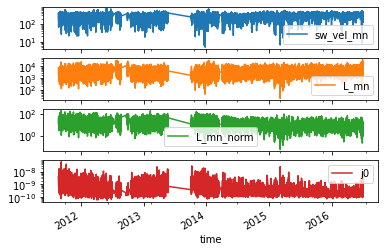

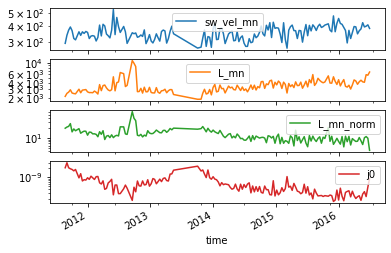

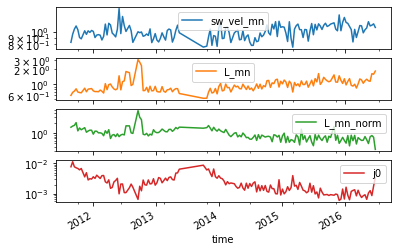

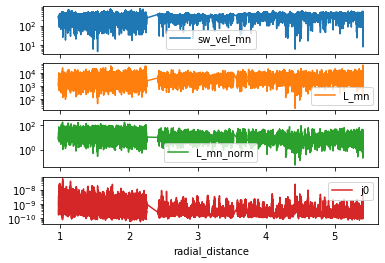

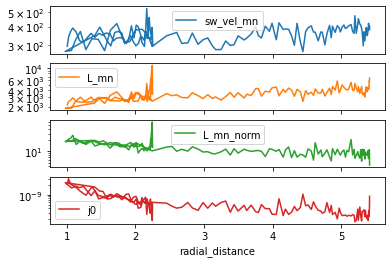

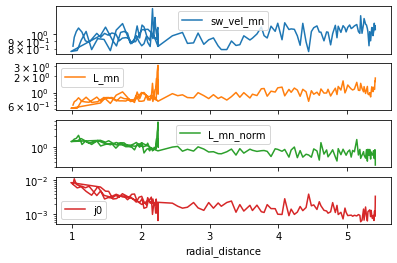

In [ ]:
overview_plot(candidates_jno_1s)

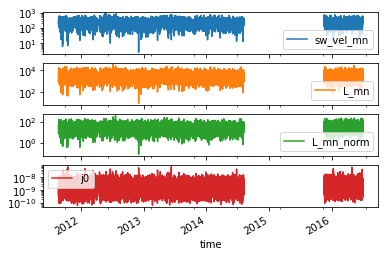

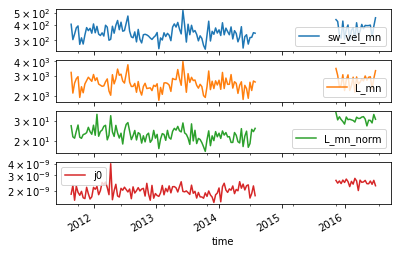

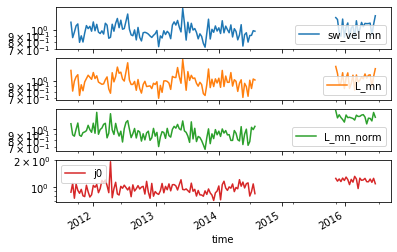

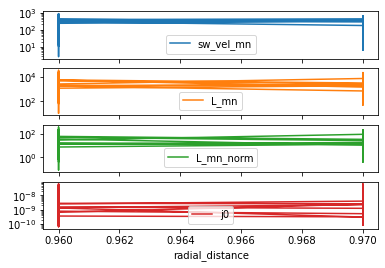

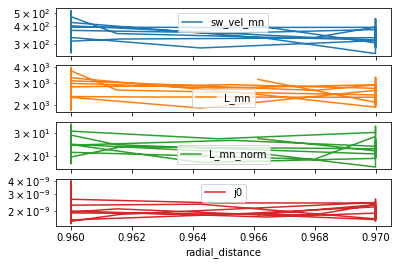

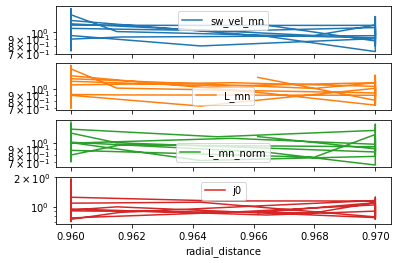

In [ ]:
overview_plot(candidates_sta_1s)

#### Utils

In [28]:
def truncate_time(data: pl.LazyFrame, every, col_name='time'):
    return data.with_columns(pl.col(col_name).dt.truncate(every).alias("truncated_time"))

In [ ]:
%%R
# Save the plot, if filename is provided
save_plot <- function(filename = NULL) {
  if (!is.null(filename)) {
    ggsave(filename = glue("../figures/{filename}.png"))
    ggsave(filename = glue("../figures/{filename}.pdf"))
  }
}

### Magnetic field strength vs. distance

In [ ]:
%%markdown

file = f"../data/jno_*.parquet"
lazy_df = pl.scan_parquet(file)

In [ ]:
%%markdown
b_cols = ["BX", "BY", "BZ"]

every = "3d"
b_df = (
    lazy_df.with_columns(
        pl_norm(b_cols).alias("B"),)
    .sort("time")
    .group_by_dynamic("time", every=every)
    .agg(
        pl.mean("B").alias("B_mean"),
    )
    .collect()
)

In [ ]:
%%markdown
alt.Chart(b_df).mark_line().encode(
    x="time",
    y="B_mean",
)

In [ ]:
%%markdown
binwidth = 0.1

b_df = (
    lazy_df.with_columns(
        (pl.col('X')/au_in_km / binwidth).floor().alias('bin_group_id').cast(pl.Int64),
        pl_norm(b_cols).alias("B"),
    ).group_by("bin_group_id").agg(
        pl.mean("B").alias("B_mean"),
    ).with_columns(
        (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
    ).collect()
)

In [ ]:
%%markdown

alt.Chart(b_df).mark_line().encode(
    x=alt.X("binned_distance").title("Distance from Sun (AU)"),
    y=alt.Y("B_mean").title("Magnetic Field Strength (nT)"),
)

### Distance and Occurrence rates versus time for JUNO

In [20]:
all_candidates

count,time,B_std,B_std_prev,count_prev,B_std_next,count_next,index_std,B_mean,dBX_vec,dBY_vec,dBZ_vec,dB_vec,index_diff,B_combined_std,B_added_std,index_fluctuation,tstart,tstop,d_star,d_time,d_tstart,d_tstop,threshold,B,B_n,BnOverB,Q_mva,b_vecL_r,b_vecL_t,b_vecL_n,dB,dBOverB,dBOverB_max,dB_l,dB_m,dB_n,…,BZ,X,Y,Z,radial_distance,sw_density,sw_temperature,model_b_r,model_b_t,model_b_n,sw_vel_r,sw_vel_t,sw_vel_n,sw_speed,duration,sw_vel_l,sw_vel_mn,L_mn,j0,ion_inertial_length,L_mn_norm,sat,Vl_x,Vl_y,Vl_z,"X, SSE","Y, SSE","Z, SSE","X, GSE","Y, GSE","Z, GSE",B_right,"Radial Distance, AU",HGI Lat. of the S/C,HGI Long. of the S/C,HGI Lat. of the S/C_right,HGI Long. of the S/C_right
u32,datetime[ns],f64,f64,u32,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,datetime[ns],datetime[ns],f64,datetime[ns],datetime[ns],datetime[ns],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,duration[ns],f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
60,2011-08-25 15:25:30,2.59028,0.892715,60,0.907528,60,2.854216,3.29237,3.89,-1.37,-1.0,4.243701,1.28895,2.241577,1.800243,1.245153,2011-08-25 15:25:00,2011-08-25 15:26:00,0.932121,2011-08-25 15:25:32.000000503,2011-08-25 15:25:25.000000503,2011-08-25 15:25:36.000000503,0.23303,3.191355,-0.595931,-0.186733,28.893747,-0.897569,0.285357,0.336067,0.199262,0.062438,0.107465,-5.64476,0.017215,0.009495,…,-1.57,1.5186e8,-3.196,-0.123,1.004,2.94905,82235.0,-0.534051,1.904381,0.632,432.236299,-18.092602,-0.0,432.614794,11s,-393.124793,180.57812,1986.359315,4.1077e-9,132.611202,14.97882,"""JNO""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
60,2011-08-25 15:33:30,2.205713,0.55294,60,0.188009,60,3.989068,3.306335,1.84,0.59,-5.39,5.725889,1.731793,2.731227,0.740949,3.686122,2011-08-25 15:33:00,2011-08-25 15:34:00,0.995251,2011-08-25 15:33:13.000000502,2011-08-25 15:33:06.000000502,2011-08-25 15:33:16.000000502,0.248813,3.044564,0.425208,0.139661,8.712477,-0.392379,-0.071747,0.917001,0.020308,0.00667,0.080201,-5.550748,0.078885,0.115626,…,0.31,1.5186e8,-3.197,-0.123,1.004,2.94905,82235.0,-0.534051,1.904381,0.632,432.236299,-18.092602,-0.0,432.614794,10s,-168.302337,398.53467,3985.346704,1.9873e-9,132.611202,30.052866,"""JNO""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
60,2011-08-25 15:37:00,1.2749,0.282139,60,0.342792,60,3.719164,3.367894,0.27,-1.03,0.63,1.237215,0.367356,0.633261,0.624931,1.01333,2011-08-25 15:36:30,2011-08-25 15:37:30,0.648633,2011-08-25 15:36:59.000000501,2011-08-25 15:36:56.000000501,2011-08-25 15:37:03.000000501,0.162158,3.494897,1.573071,0.450105,21.143308,0.365239,-0.542554,0.756463,0.169,0.048356,0.058007,2.561052,0.095052,0.042149,…,1.97,1.5186e8,-3.197,-0.123,1.004,2.94905,82235.0,-0.534051,1.904381,0.632,432.236299,-18.092602,-0.0,432.614794,7s,167.685825,398.794464,2791.561245,1.2943e-9,132.611202,21.05072,"""JNO""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
60,2011-08-25 15:54:30,0.810663,0.238493,60,0.313628,60,2.584792,3.546181,-0.36,0.47,-1.5,1.612607,0.454745,0.965793,0.552121,1.749241,2011-08-25 15:54:00,2011-08-25 15:55:00,0.494419,2011-08-25 15:54:15.000000500,2011-08-25 15:54:13.000000500,2011-08-25 15:54:19.000000500,0.123605,3.543821,3.475578,0.980743,8.262141,0.072371,-0.443734,0.893232,-0.038909,0.010979,0.024857,-1.428624,-0.195891,0.032567,…,1.39,1.5187e8,-3.198,-0.123,1.004,2.94905,82235.0,-0.534051,1.904381,0.632,432.236299,-18.092602,-0.0,432.614794,6s,39.309713,430.825146,2584.950876,9.1324e-10,132.611202,19.492704,"""JNO""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
60,2011-08-25 16:12:00,1.117192,0.316177,60,0.557412,60,2.004247,3.579415,1.53,0.47,0.76,1.771835,0.495007,0.982453,0.873589,1.124617,2011-08-25 16:11:30,2011-08-25 16:12:30,0.942603,2011-08-25 16:12:09.000000498,2011-08-25 16:12:07.000000498,2011-08-25 16:12:12.000000498,0.2356

In [ ]:
%%markdown
properties = {'width': 900, 'height': 150}

chart1 = alt.Chart(candidates_pl).mark_point().encode(
    x=alt.X('yearmonthdate(time)').axis(labels=False, title=None),
    y=alt.Y('mean(distance_in_AU)').axis(title='Distance (AU)'),
).properties(**properties)

chart2 = alt.Chart(candidates_pl).mark_point().encode(
    x='yearmonth(time)',
    y='count()',
    color = 'type',
    row='type'
).properties(**properties)

chart1 & chart2

properties = {'width': 900, 'height': 150}

chart1 = alt.Chart(candidates_pl).mark_point().encode(
    x=alt.X('yearmonthdate(time)').axis(labels=False, title=None),
    y=alt.Y('mean(distance_in_AU)').axis(title='Distance (AU)'),
).properties(**properties)

chart2 = alt.Chart(candidates_pl).mark_point().encode(
    x='yearmonth(time)',
    y='count()',
    color = 'type',
    row='type'
).properties(**properties)

chart1 & chart2


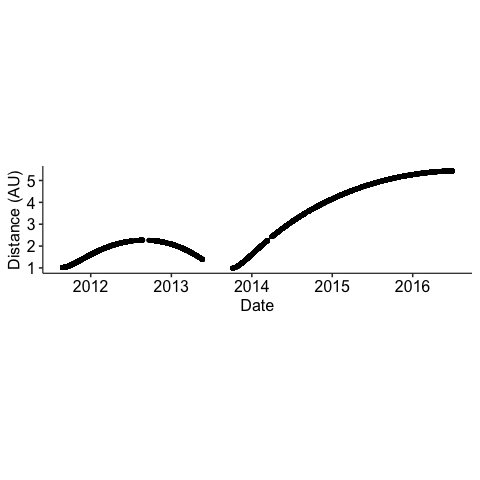

In [ ]:
%%R -i jno_candidates -c conv_pl

p <- ggplot(jno_candidates, aes(x = time, y = distance_in_AU)) + 
  geom_point() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

print(p)

# save_plot(filename = "distance_by_date")

The following codes deal with data gap better by filling the gap with the `null` value.

In [26]:
every = pd.Timedelta("3d")
base_amplification_factor = every / pd.Timedelta("1d")

df = (
    jno_candidates_filtered.pipe(truncate_time, every=every)
    .group_by("truncated_time")
    .agg(
        pl.count() / base_amplification_factor,
        pl.mean("distance_in_AU"),
    )
    .upsample("truncated_time", every=every)
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 5>:5                                                                              │
│                                                                                                  │
│    2 base_amplification_factor = every / pd.Timedelta("1d")                                      │
│    3                                                                                             │
│    4 df = (                                                                                      │
│ ❱  5 │   jno_candidates_filtered.pipe(truncate_time, every=every)                                │
│    6 │   .group_by("truncated_time")                                                             │
│    7 │   .agg(                                                                                   │
│    8 │   │   pl.count() / base_amplification_factor,                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
NameError: name 'truncate_time' is not defined

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


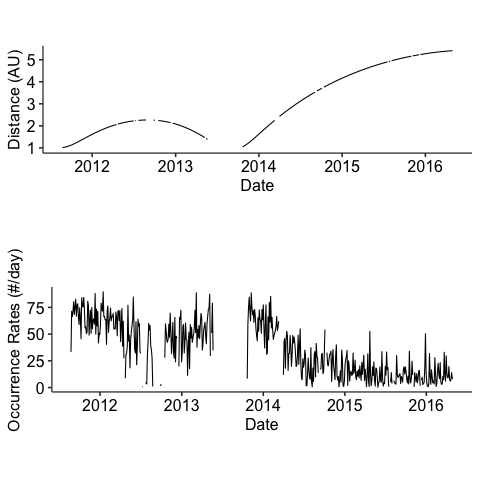

In [ ]:
%%R -i df -c conv_pl

df$date <- as.Date(df$truncated_time)
p1 <- ggplot(df, aes(x = date, y = distance_in_AU)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Distance (AU)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)
  
p2 <- ggplot(df, aes(x = date, y = count)) + 
  geom_line() + # Plot distance by date
  labs(x = "Date", y = "Occurrence Rates (#/day)") +
  theme_pubr(base_size = 16) + 
  theme(aspect.ratio=0.25)

p <- ggarrange(p1, p2, nrow = 2)

save_plot("distance_and_or")
p

### Occurrence rates versus time for All missions

In [67]:
candidates_jno_tau_60s.columns


[
    'count',
    'time',
    'B_std',
    'B_std_prev',
    'count_prev',
    'B_std_next',
    'count_next',
    'index_std',
    'B_mean',
    'dBX_vec',
    'dBY_vec',
    'dBZ_vec',
    'dB_vec',
    'index_diff',
    'B_combined_std',
    'B_added_std',
    'index_fluctuation',
    'tstart',
    'tstop',
    'd_star',
    'd_time',
    'd_tstart',
    'd_tstop',
    'threshold',
    'B',
    'B_n',
    'BnOverB',
    'Q_mva',
    'b_vecL_r',
    'b_vecL_t',
    'b_vecL_n',
    'dB',
    'dBOverB',
    'dBOverB_max',
    'dB_l',
    'dB_m',
    'dB_n',
    'eig0',
    'eig1',
    'eig2',
    'type',
    'rotation_angle',
    'BX',
    'BY',
    'BZ',
    'X',
    'Y',
    'Z',
    'radial_distance',
    'sw_density',
    'sw_temperature',
    'model_b_r',
    'model_b_t',
    'model_b_n',
    'sw_vel_r',
    'sw_vel_t',
    'sw_vel_n',
    'sw_speed',
    'duration',
    'sw_vel_l',
    'sw_vel_mn',
    'L_mn',
    'j0',
    'ion_inertial_length',
    'L_mn_norm',
    'distance'

In [73]:
def get_count(candidates: pl.DataFrame, truncation_delta="5d", cols=None):
    every = pd.Timedelta(truncation_delta)

    temp_df = (
        candidates.pipe(truncate_time, every=every)
        .group_by("truncated_time")
        .agg(
            pl.count(),
            cs.by_name(cols).mean() if cols != None else None,
        )
    )
    return temp_df

In [32]:
#| export
def concat_partitions(partitioned_input) -> pl.LazyFrame:
    """Concatenate input partitions into one pandas DataFrame.

    Args:
        partitioned_input: A dictionary with partition ids as keys and load functions as values.

    Returns:
        Pandas DataFrame representing a concatenation of all loaded partitions.
    """
    partitions_data = [
        partition_load_func() for partition_load_func in partitioned_input.values()
    ]  # load the actual partition data
    result = pl.concat(partitions_data)
    return result

In [34]:
s_resolution = timedelta(minutes=1)
l_resolution = timedelta(days=30)

In [74]:
jno_candidates_count = get_count(candidates_jno_tau_60s, l_resolution, cols=["radial_distance"])
sta_candidates_count = get_count(candidates_sta_tau_60s, l_resolution, cols=["radial_distance"])
thb_candidates_count = get_count(candidates_thb_tau_60s, l_resolution)


In [33]:
sta_mag_1s = concat_partitions(catalog.load("sta.primary_mag_rtn_1s"))
jno_mag_1s = concat_partitions(catalog.load("jno.primary_mag_rtn_1s"))
thb_mag = concat_partitions(catalog.load("thb.primary_mag_rtn_4s"))


[10/16/23 10:08:03] INFO     Loading data from 'jno.primary_mag_rtn_1s' (PartitionedDataset)... ]8;id=345690;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=367044;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#492\492]8;;\

In [75]:
jno_candidates_count_normalized = normalize_count(jno_candidates_count, jno_mag_1s, s_resolution, l_resolution)
sta_candidates_count_normalized = normalize_count(sta_candidates_count, sta_mag_1s, s_resolution, l_resolution)
thb_candidates_count_normalized = normalize_count(thb_candidates_count, thb_mag, s_resolution, l_resolution)


In [77]:
all_candidates_count_normalized = pl.concat(
    [
        jno_candidates_count_normalized.with_columns(sat=pl.lit("JNO")),
        sta_candidates_count_normalized.with_columns(sat=pl.lit("STA")),
        thb_candidates_count_normalized.with_columns(sat=pl.lit("THB")),
    ],
    how="diagonal"
)

In [102]:
df = all_candidates_count_normalized.pivot(["count", "radial_distance"], "truncated_time", "sat").with_columns(
    JNO_over_STA = pl.col('count_sat_JNO') / pl.col('count_sat_STA'),
    JNO_over_THB = pl.col('count_sat_JNO') / pl.col('count_sat_THB'),
).melt(id_vars=["truncated_time", "radial_distance_sat_JNO"], value_vars=["JNO_over_STA", "JNO_over_THB"])

[10/16/23 11:03:08] WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=904143;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=759830;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=712704;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=136535;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=348200;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=934555;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=389879;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=255436;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=634360;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=145512;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: use_inf_as_na option is deprecated and will be removed in ]8;id=845164;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=317543;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Convert inf values to NaN before operating instead.                 
                                                                                                                   

                    WARNING  FutureWarning: use_inf_as_na option is deprecated and will be removed in ]8;id=588365;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=558305;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Convert inf values to NaN before operating instead.                 
                                                                                                                   

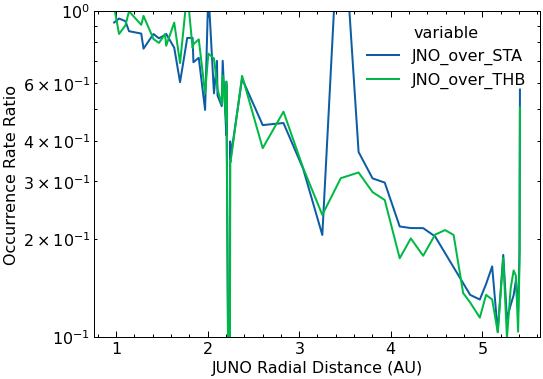

In [104]:
ax = sns.lineplot(x='radial_distance_sat_JNO', y='value', hue='variable', data=df)
ax.set_ylim(1e-1, 1)
ax.set_yscale('log')
ax.set_xlabel("JUNO Radial Distance (AU)")
ax.set_ylabel("Occurrence Rate Ratio")
savefig('occurrence_rate_ratio')

[10/16/23 10:30:22] WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=451493;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=23450;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=331146;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=960625;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=437070;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=60608;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=487763;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=944844;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: is_categorical_dtype is deprecated and will be removed in ]8;id=713671;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=191829;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Use isinstance(dtype, CategoricalDtype) instead                     
                                                                                                                   

                    WARNING  FutureWarning: use_inf_as_na option is deprecated and will be removed in ]8;id=780647;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=273034;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Convert inf values to NaN before operating instead.                 
                                                                                                                   

                    WARNING  FutureWarning: use_inf_as_na option is deprecated and will be removed in ]8;id=793377;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py\logger.py]8;;\:]8;id=25780;file:///Users/zijin/mambaforge/envs/cool_planet/lib/python3.10/site-packages/astropy/logger.py#205\205]8;;\
                             a future version. Convert inf values to NaN before operating instead.                 
                                                                                                                   

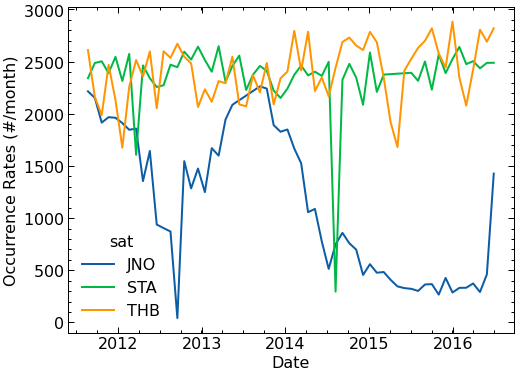

In [59]:

ax = sns.lineplot(all_candidates_count_normalized, x="truncated_time", y="count", hue="sat")
# Set the y-axis label
ax.set_ylabel("Occurrence Rates (#/month)")
ax.set_xlabel("Date")

savefig("occurrence_rates")

### Classification of candidates

In [ ]:
sns.jointplot(
    candidates_jno_tau_60s,
    x='dBOverB', y='BnOverB',
    # kind='kde',
    kind="hex",
)

In [ ]:
sns.jointplot(
    all_candidates,
    x='dBOverB', y='BnOverB',
    # kind='kde',
    kind="hex",
)

### Distribution of the DD types

##### Plot distribution of types for each missions


In [ ]:
alt.Chart(all_candidates).encode(
    x=alt.X("count()").stack("normalize").title("Share of ID types"),
    y=alt.Y('sat').title(None),
    color='type',
).mark_bar()

# alt.Chart(distributions).encode(
#     alt.X('ratio:Q', title='DD type distribution').axis(format='.0%'),
#     y=alt.Y('sat', title=None),
#     color='type',
# ).mark_bar()

In [23]:
distributions = all_candidates.group_by("sat", "type").agg(pl.count()).with_columns(
    (pl.col("count") / pl.sum("count").over("sat")).alias("ratio")
)
count_table = distributions.to_pandas().pivot(index='sat', columns='type', values='count')[['RD', 'TD', 'ED', 'ND']]
ratio_table = distributions.to_pandas().pivot(index='sat', columns='type', values='ratio')[['RD', 'TD', 'ED', 'ND']]
# display(distributions.to_pandas().pivot(index='sat', columns='type', values='ratio')[['RD', 'TD', 'ED', 'ND']].style.format("{:.0%}"))
display(count_table, ratio_table.style.format("{:.0%}"))


type,RD,TD,ED,ND
sat,,,,
JNO,34003,1576,15595,1277
STA,71337,2905,29916,1727
THB,26793,1093,8359,1193


type,RD,TD,ED,ND
sat,,,,
JNO,65%,3%,30%,2%
STA,67%,3%,28%,2%
THB,72%,3%,22%,3%


##### Plot distribution of types for each missions **over time**

In [25]:
alt.Chart(all_candidates).mark_bar(binSpacing=0).encode(
    x="yearmonth(time)",
    y=alt.Y("count()").stack("normalize").title("Share of ID types"),
    row=alt.Row("sat").title(None),
    color="type",
).configure_axis(grid=False).properties(height=100)

alt.Chart(...)

In [ ]:
%%R
plot_type_distribution <- function(data, bin_width = 30) { 
    data$date_only <- as.Date(data$time)
    
    p <- ggplot(data, aes(date_only, fill = type)) +
        geom_histogram(binwidth = bin_width, position = "fill") + 
        theme_pubr(base_size = 16)
        
    return(p)
}

p1 <- plot_type_distribution(jno_candidates)
p2 <- plot_type_distribution(thb_candidates)
p3 <- plot_type_distribution(sta_candidates)

p <- ggarrange(
    p1 + rremove("xlab"),
    p2 + rremove("xlab"), p3, 
    nrow = 3, align = 'hv', 
    labels=list("JUNO", "ARTEMIS-B", "STEREO-A"), hjust=0, vjust=0,
    legend = 'right', common.legend = TRUE
)
# save_plot(filename = "type_distribution")
p

### Occurrence rates versus time of different types

Plot the occurernce rate of each type of IDs as a function of time

In [ ]:
%%R
plot_count_raw <- function(data, bin_width = 5) {
  # Transform date column
  data$date_only <- as.Date(data$time)
  
  # Plot
  p <- ggplot(data, aes(x = date_only)) + 
    geom_freqpoly(aes(color = "All"), binwidth = bin_width) + # Overall frequency by day
    geom_freqpoly(aes(color = type), binwidth = bin_width) + # Frequency by day split by type
    labs(x = "Date") +
    theme_pubr(base_size = 16) +
    theme(
      aspect.ratio=0.25,
      )
  
  # Print the plot
  print(p)
  
  return(p)
}

In [ ]:
%%R
p1 <- plot_count_raw(jno_candidates)
p2 <- plot_count_raw(thb_candidates)
p3 <- plot_count_raw(sta_candidates)

p <- ggarrange(
    p1 + rremove("xlab"),
    p2 + rremove("xlab"), p3, 
    nrow = 3, align = 'hv', 
    labels=list("JUNO", "ARTEMIS-B", "STEREO-A"), hjust=0,
    legend = 'right', common.legend = TRUE)

# save_plot("count_raw_multi")
p

As we can see different types of IDs have different Occurrence rates. To demonstrate their relative change, amplify TD-like IDs by 10 times.

In [ ]:
import pandas as pd
import polars as pl

In [ ]:
def get_count_by_type(candidates: pl.DataFrame, truncation_delta="5d"):
    every = pd.Timedelta(truncation_delta)
    base_amplification_factor = every / pd.Timedelta("1d")
    amplification_factors = {
        "RD": 1 / base_amplification_factor,
        "ED": 1 / base_amplification_factor,
        "TD": 10 / base_amplification_factor,
        "ND": 10 / base_amplification_factor,
    }

    temp_df = (
        candidates.pipe(truncate_time, every=every)
        .group_by("truncated_time", "type")
        .agg(
            pl.count(),
        )
    )

    type_dfs = []
    for type, group in temp_df.group_by("type"):
        type_df = (
            group.sort("truncated_time")
            .upsample("truncated_time", every=every)
            .with_columns(
                pl.col("type").fill_null(type),
                pl.col("count") * amplification_factors[type],
            )
        )
        type_dfs.append(type_df)

    df = pl.concat(type_dfs)
    return df

In [ ]:
%%R
plot_count_am <- function(df) {
  tmp <- df %>%
    mutate(name2=type)
  tmp$date <- as.Date(tmp$truncated_time)
  tmp$type <- factor(tmp$type, levels = c("RD", "ED", "TD", "ND"))

  p <- tmp %>%
    ggplot( aes(date, count)) +
      geom_line( data=tmp %>% dplyr::select(-type), aes(group=name2), color="grey", linewidth=0.5, alpha=0.5) +
      geom_line( aes(color=type), color="#69b3a2")+
      facet_grid(type ~ .) +
      labs(x = "Date", y = "Occurrence Rates (#/day)") +
      theme_pubr(base_size = 16) +
      theme(aspect.ratio=0.25)
  return(p)
}

In [ ]:
jno_count_filtered_df = get_count_by_type(jno_candidates_filtered)


In [ ]:
%%R -i jno_count_filtered_df -c conv_pl
plot_count_am(jno_count_df)
# save_plot('jno_count_am')

In [ ]:
thb_count_df = get_count_by_type(
    candidates_thb_tau_60s
)

In [ ]:
%%R -i thb_count_df -c conv_pl
plot_count_am(thb_count_df)
# save_plot('thb_count_am')

#### Histogram of Occurrence rates (not normalized)

In [ ]:
jno_candidates_rd_like = candidates_jno_tau_60s.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = candidates_jno_tau_60s.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

thb_candidates_rd_like = candidates_thb_tau_60s.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

thb_candidates_td_like = candidates_thb_tau_60s.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%R -i jno_candidates -c conv_pl
%R -i jno_candidates_rd_like -c conv_pl
%R -i jno_candidates_td_like -c conv_pl
%R -i thb_candidates -c conv_pl
%R -i thb_candidates_rd_like -c conv_pl
%R -i thb_candidates_td_like -c conv_pl

In [ ]:
%%R

p1 <- gghistogram(jno_candidates, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p2 <- gghistogram(jno_candidates_rd_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p3 <- gghistogram(jno_candidates_td_like, x = "time",
   rug = TRUE,
   color = "type", fill = "type",
   )

p <- ggarrange(p1, p2, p3, nrow = 3)
p

#### Histogram of Occurrence rates (normalized)

In [ ]:
s_resolution = timedelta(minutes=1)
l_resolution = timedelta(days=30)

In [ ]:
sat = 'jno'
files = f"../data/{sat}_data_*.parquet"

data = pl.scan_parquet(files).set_sorted('time')
jno_count_filtered_df = get_count_by_type(jno_candidates_filtered, l_resolution)
jno_count_normalized_filtered_df = normalize_count(jno_count_filtered_df, data, s_resolution, l_resolution)

In [ ]:
sat = 'thb'
files = f"../data/{sat}_data_sw.parquet"

data = pl.scan_parquet(files).set_sorted('time').collect()
thb_count_df = get_count_by_type(candidates_thb_tau_60s, l_resolution)
thb_count_normalized_df = normalize_count(thb_count_df, data, s_resolution, l_resolution)

In [ ]:
sat = 'STA'
files = f"../data/{sat}_data_downsampled.parquet"

data = pl.scan_parquet(files).set_sorted('time').collect()
sta_count_df = get_count_by_type(candidates_sta_tau_60s, l_resolution)
sta_count_normalized_df = normalize_count(sta_count_df, data, s_resolution, l_resolution)

In [ ]:
%R -i thb_count_normalized_df -c conv_pl
%R -i sta_count_normalized_df -c conv_pl
%R -i jno_count_normalized_df -c conv_pl

In [ ]:
%%R
p1 <- plot_count_am(jno_count_normalized_df)

In [ ]:
%%R
p1_f <- plot_count_am(jno_count_normalized_filtered_df)
p1_f
# save_plot("count_am_jno_filtered")

In [ ]:
%%R
p2 <- plot_count_am(thb_count_normalized_df)
save_plot("count_am_thb")

In [ ]:
%%R
p3 <- plot_count_am(sta_count_normalized_df)
save_plot("count_am_sta")

### Occurrence rates versus distance

In [ ]:
temp_candidates_pl = candidates_jno_tau_60s.filter(
    pl.col("time") > pd.Timestamp("2013-06-01")  # Where distance increases singularly
)

In [ ]:
%%R -i temp_candidates_pl -c conv_pl
gghistogram(temp_candidates_pl, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count")

In [ ]:
jno_candidates_rd_like = temp_candidates_pl.filter(  
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = temp_candidates_pl.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%%R -i candidates_rd_like -c conv_pl

gghistogram(candidates_rd_like, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)

In [ ]:
%%R -i candidates_td_like -c conv_pl

gghistogram(candidates_td_like, x="distance_in_AU", rug=TRUE, color="type", fill="type", binwidth=0.1) + 
  labs(x="Distance (AU)", y="Count") +
  theme_pubr(base_size = 16)

In [ ]:
binwidth = 0.1
temp_df = temp_candidates_pl.with_columns(
    (pl.col('distance_in_AU')/binwidth).floor().alias('bin_group_id').cast(pl.Int64),
).group_by("bin_group_id",'type').agg(
    (pl.max("time") - pl.min("time")).alias("duration"),
    pl.col('distance_in_AU').mean().alias("mean_distance"),
    pl.count()
).with_columns(
    (pl.col("duration") / pd.Timedelta(hours=24)).alias("duration_in_days"),
).filter(
    pl.col("duration_in_days") > 1 # filter out candidates that occur within 1 day
).with_columns(
    (pl.col("count") / pl.col("duration_in_days")).alias("occurrence_rate")
).sort(
    "bin_group_id"
)

In [ ]:
_ = pl.DataFrame({'bin_group_id': pl.arange(temp_df['bin_group_id'].min(), temp_df['bin_group_id'].max()+1, eager=True)})

type_dfs = []
for type, jno_fp in temp_df.group_by("type"):
    type_df = _.join(jno_fp, on="bin_group_id", how="left").with_columns(
            pl.col("type").fill_null(type),
        )
    type_dfs.append(type_df)

or_df = pl.concat(type_dfs).with_columns(
    (pl.col("bin_group_id") * binwidth).alias("binned_distance"),
)

In [ ]:
%%R -i or_df -c conv_pl
p <- ggplot(or_df, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
save_plot("or_by_distance")
p

In [ ]:
jno_candidates_rd_like = or_df.filter(
    (pl.col("type") == "RD") | (pl.col("type") == "ED")
)

jno_candidates_td_like = or_df.filter(
    (pl.col("type") == "TD") | (pl.col("type") == "ND")
)

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggplot(candidates_rd_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
save_plot("or_by_distance_rd")
p

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggplot(candidates_td_like, aes(x=binned_distance, y=occurrence_rate, color=type)) +
    geom_point() +
    geom_line() +
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
save_plot("or_by_distance_td")
p

In [ ]:
%%R -i candidates_rd_like -c conv_pl
p <- ggscatter(candidates_rd_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)
    
save_plot("or_by_distance_rd")
p

In [ ]:
%%R -i candidates_td_like -c conv_pl
p <- ggscatter(candidates_td_like, x = "mean_distance", y = "occurrence_rate",
        color = "type",
        add = "loess",  # Add regressin line
        add.params = list(fill = "lightgray"), # Customize reg. line
        shape = 21, size=3, # Points color, shape and size
        conf.int = TRUE, # Add confidence interval
        cor.coef = TRUE, # Add correlation coefficient. see ?stat_cor
        cor.coeff.args = list(method = "pearson", label.x = 3, label.sep = "\n")
    ) + 
    labs(x="Distance from the Sun (AU)", y="Occurrence rate (per day)", color="Type") +
    theme_pubr(base_size = 16)

save_plot("or_by_distance_td_fit")
p

### $dB_l/B$

- $dB_l/B$ does not show any clear correlation with time.

In [ ]:
every = pd.Timedelta("30d")

data = candidates_jno_tau_60s.with_columns(
    (pl_norm(["dB_l", "dB_l", "dB_l"]) / pl.col('B')).alias("dB_vec_over_B"),
    (pl.col("dB_l") / pl.col('B') ).abs().alias("dB_l_over_B"),
).pipe(truncate_time, every=every)

%R -i data -c conv_pl

In [ ]:
data_parallel = data.filter(
    (pl.col("Vl_x") >= 0.8) | (pl.col("Vl_x") <= -0.8)
)

data_per = data.filter(
    (pl.col("Vl_x") < 0.8) & (pl.col("Vl_x") > -0.8)
)

%R -i data_parallel -c conv_pl
%R -i data_per -c conv_pl

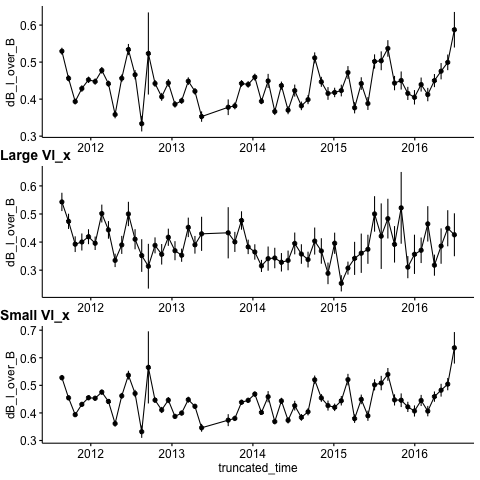

In [ ]:
%%R
p1 <- ggline(
    data, x = "truncated_time", y = "dB_l_over_B",
    add = c("mean_se")
)

p2 <- ggline(
    data_parallel, x = "truncated_time", y = "dB_l_over_B",
    add = c("mean_se")
)

p3 <- ggline(
    data_per, x = "truncated_time", y = "dB_l_over_B",
    add = c("mean_se")
)

ggarrange(
    p1 + rremove("xlab"), 
    p2 + rremove("xlab"), 
    p3, 
    nrow=3,
    labels=list("All", "Large Vl_x", "Small Vl_x"), hjust=0, vjust=0
)

No clear trend is found. Let see if there is any trend in the distribution of $dB_l/B$.

In [ ]:
base = alt.Chart(data).encode(
    x=alt.X('yearmonth(time)'),
    y=alt.Y('mean(dB_l_over_B)'),
)

heatmap = alt.Chart(data).mark_rect().encode(
    alt.X('yearmonth(time):O'),
    # alt.X('truncated_time:O'), # NOTE: this is not formatted correctly
    alt.Y('dB_l_over_B:Q').bin(maxbins=30),
    alt.Color('count()'),
)

heatmap + base.mark_line()

alt.LayerChart(...)

However the `count` changes a lot with time. We need to normalize by time to see how the distribution of $dB_l/B$ changes with time...

In [ ]:
def bin(data: pl.DataFrame, col_name, maxbins=10, start=None, stop=None):
    
    start = start or data.get_column(col_name).min()
    stop = stop or data.get_column(col_name).max()
    bins = np.linspace(start, stop, maxbins)
    
    cut = data.get_column(col_name).cut(
        bins, 
    ).alias("cut")
    return data.with_columns(cut)

def scale(data, col_name = 'count', over_col_name=None):
    return data.with_columns(
        (pl.col(col_name) / pl.sum(col_name).over(over_col_name)).alias("ratio")
    )

In [ ]:
binned_data = (
    data.pipe(bin, "dB_l_over_B", maxbins=20, start=0, stop=2)
    .group_by("truncated_time", "cut")
    .agg(pl.count())
    .filter(pl.col("count") > 1)
    .pipe(scale, col_name="count", over_col_name="truncated_time")
)

base = alt.Chart(binned_data).mark_rect().encode(
    alt.X("truncated_time:O"),  # NOTE: this is not formatted correctly
    alt.Y("cut:O").sort("descending"),
    alt.Color("ratio"),
)

base
# Note: no big difference even in log scale
# base.encode(color=alt.Color("ratio").scale(type="log"))

alt.Chart(...)

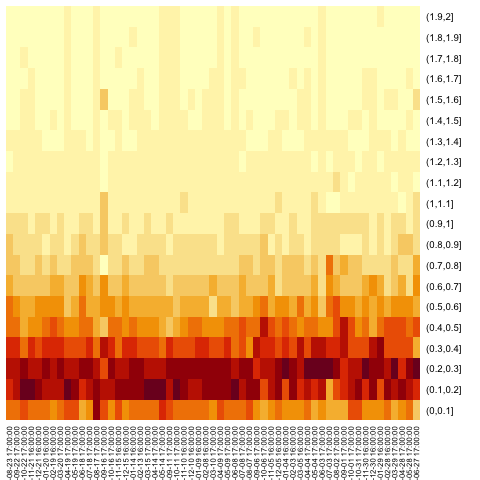

In [ ]:

%%R
# 1. Binning and Counting
bins <- 20
min_val <- 0
max_val <- 2
breaks_seq <- seq(min_val, max_val, length.out = bins + 1)  # +1 because for N bins, you need N+1 break points
data$y_bin <- cut(data$dB_l_over_B, breaks = breaks_seq)

# 2. Create a Matrix
mat <- with(data, table(y_bin, truncated_time))

# 4. Plotting using heatmap
heatmap(mat, Colv = NA, Rowv = NA, scale = "column")


## Obsolete codes

### Waiting time

### Amplitude

In [ ]:
temp_candidates = get_candidates(candidates_jno_tau_60s, 'RD')
temp_candidates = pdp_calc_duration(temp_candidates)
temp_candidates

In [ ]:
plot_candidates(temp_candidates)

### RD paramters

In [ ]:
# BUG: `Bm0` may be larger than `radius`

def calculate_RD_parameter(Bl, Bm, Bn=None, num_avg_points=8):
    """Calculate magnetic field parameters for rotation discontinuity (RD) identification.

    Args:
        Bl (xarray.DataArray): 'Bl' component of the magnetic field.
        Bm (xarray.DataArray): 'Bm' component of the magnetic field.
        Bn (xarray.DataArray, optional): 'Bn' component of the magnetic field. Defaults to None.
        num_avg_points (int): Number of points at the start and end of data for averaging.

    Returns:
        tuple: A tuple containing 'Bl_max' and 'Bm0', and 'Bn0' if 'Bn' was provided.
    """
    
    radius = np.sqrt(Bl**2 + Bm**2).mean(dim="time")

    # Calculate 'Bm0'
    Bm_start = Bm[:num_avg_points].mean(dim="time")
    Bm_end = Bm[-num_avg_points:].mean(dim="time")
    Bm0 = (Bm_start + Bm_end) / 2
    
    # Calculate 'Bl_max': average of the absolute values of 'Bl' at the start and end of the data
    # Bl_start = Bl[:num_avg_points].mean(dim="time")
    # Bl_end = Bl[-num_avg_points:].mean(dim="time")
    # Bl_max = (np.abs(Bl_start) + np.abs(Bl_end)) / 2
    
    # Calculate 'Bl_max': using radius, more reliable
    Bl_max = np.sqrt(radius**2 - Bm0**2)

    # Calculate 'Bn0' if 'Bn' is provided, else return 'Bl_max' and 'Bm0' only
    if Bn is not None:
        Bn0 = Bn.mean(dim="time")
        return Bl_max.values, Bm0.values, Bn0.values

    return Bl_max.values, Bm0.values


def RD_parameter(data, tstart, tstop):
    mva(data, tstart, tstop)
    mva_data = get_data("fgm_rot", xarray=True)
        
    Bl = mva_data.sel(v_dim=0)
    Bm = mva_data.sel(v_dim=1)
    Bn = mva_data.sel(v_dim=2)

    Bl_max, Bm0, Bn0 = calculate_RD_parameter(Bl, Bm, Bn)
    return pd.Series({
        'Bl_max':Bl_max, 
        'Bm0': Bm0, 
        'Bn0': Bn0
        })



### TD parameters

$$PVI(t) = B(t + \tau/2) - B(t - \tau/2) = B_+(t) - B_-(t)$$

In [ ]:
def duration_TD(vec: xr.DataArray, threshold_ratio=0.2) -> pd.Series:
    # Calculate magnitude and its difference
    vec_mag = calc_vec_mag(vec)
    vec_mag_diff = vec_mag.differentiate("time")

    # Determine if the trend is increasing or decreasing
    increasing = vec_mag[0] < vec_mag[-1]

    # Determine d_star based on trend
    d_star_index = vec_mag_diff.argmax(dim="time").values if increasing else vec_mag_diff.argmin(dim="time").values
    d_star = vec_mag_diff[d_star_index].values
    d_star_time = vec_mag_diff.time[d_star_index].values
    
    threshold = d_star * threshold_ratio

    # Determine start time
    pre_vec_mag = vec_mag_diff[0:d_star_index]
    condition = pre_vec_mag > threshold if increasing else pre_vec_mag < threshold
    start_index = np.where(condition)[0][0]
    start_time = pre_vec_mag.time[start_index].values
    logger.debug(f'start_index: {start_index}, start_time: {start_time}')

    # Determine stop time
    post_vec_mag = vec_mag_diff[d_star_index:]
    condition = post_vec_mag > threshold if increasing else post_vec_mag < threshold
    end_index = np.where(condition)[0][-1]
    end_time = post_vec_mag.time[end_index].values

    return pd.Series({
        'TD_type': "increasing" if increasing else "decreasing",
        'TD_d_star': d_star,
        'TD_star_time': d_star_time,
        'TD_start': start_time,
        'TD_stop': end_time,
    })

pdp_TD = pdp.PdPipeline([
    pdp.ApplyToRows(lambda candidate: duration_TD(get_candidate_data_xr(candidate)) if candidate['type']=='TD' else None, func_desc='calculating duration parameters of TD'),
])

# duration_TD(get_candidate_data(TD_candidates.sample().iloc[0]))

In [ ]:
TD_candidates = pdp_TD(TD_candidates)

In [ ]:
# plot_candidates(TD_candidates, plot_func=plot_TD_candidate)

### Plotting candidates of different types of discontinuities

In [ ]:
# alt.Chart(candidates).mark_point().encode(
#     x='yearmonth(time)',
#     y='count()',
#     color='type',
# )

In [ ]:
alt.Chart(candidates_jno_tau_60s.to_pandas()).mark_point().encode(
    x='X',
    y='count(type)',
    color='type',
)

In [ ]:
plot_candidates(candidates_jno_tau_60s, candidate_type='TD')

In [ ]:
plot_candidates(candidates_jno_tau_60s, candidate_type='RD')

In [ ]:
plot_candidates(candidates_jno_tau_60s, candidate_type='ED')

In [ ]:
plot_candidates(candidates_jno_tau_60s, candidate_type='ND')

### Occurrence rates

In [ ]:
# calculate the Occurrence rates of different types of ID
def Occurrence_rate(candidates, candidate_type):
    return len(candidates[candidates['type'] == candidate_type]) / len(candidates)

def time_Occurrence_rate(candidates):
    if len(candidates) <= 1:
        return None
    else:
        return (candidates.iloc[-1]['tstop'] - candidates.iloc[0]['tstart']) / (len(candidates) -1)

CANDIDATE_TYPES = ['RD', 'TD', 'ED', 'ND']

for candidate_type in CANDIDATE_TYPES:
    logger.info(f"Occurrence rate of {candidate_type}: {Occurrence_rate(candidates_jno_tau_60s, candidate_type)}")
    logger.info(f"Time Occurrence rate of {candidate_type}: {time_Occurrence_rate(candidates_jno_tau_60s[candidates_jno_tau_60s['type'] == candidate_type])}")

In [ ]:
pdp.ColByFrameFunc("R", lambda df: df[['X','Y', 'Z']].apply(np.linalg.norm, axis=1), func_desc='calculating R')(candidates_jno_tau_60s)

In [ ]:
candidates_jno_tau_60s.plot(x="X", y="d_star")

### Duration

In [ ]:
# candidates.update(pdp_calibrate_duration.apply(temp_candidates))

In [ ]:
#| code-summary: calculate the PVI series for a given time series
def calculate_PVI_xr(vec: xr.DataArray, tau, resample_frequency = None, interval_of_averaging=None):
    """
    This function calculates the Partial Variance of Increments (PVI) series for a given time series.

    Parameters:
    vec (xr.DataArray): The input time series with two dimensions `time` and `v_dim`.
    tau (int): The time lag, in unit `s`,typically selected to lie in the inertial range of the fluctuations.
    resample_frequency (int): The resample frequency, in unit `s`. If None, defaults to tau.
    interval_of_averaging (int): The number of samples over which to compute the trailing average. It's often chosen to be comparable to, or greater than, a correlation length (or time) of the signal.

    Returns:
    PVI_series (np.array): The resulting PVI series.
    """
    
    # Sample the vector at the given time lag (tau)
    # vec_sampled = vec.resample(time=tau).mean(dim='time')
    if resample_frequency is None:
        resample_frequency = tau

    # Interpolate to a regular time grid
    vec_sampled = vec.resample(time=pd.Timedelta(resample_frequency, unit='s')).interpolate('linear')
    
    # Note: Xarray enforces alignment between index Coordinates (that is, coordinates with the same name as a dimension, marked by *) on objects used in binary operations.
    vec_plus = vec_sampled.assign_coords({'time': vec_sampled['time'] - pd.Timedelta(tau/2, unit='s')})
    vec_minus = vec_sampled.assign_coords({'time': vec_sampled['time'] + pd.Timedelta(tau/2, unit='s')})
    increments  = vec_plus - vec_minus

    # Calculate the magnitudes of these increments
    mag_increments = linalg.norm(increments, dims='v_dim')
    # logger.info(f"Magnitude of increments: {mag_increments}")

    # Square the magnitudes of the increments, and compute a moving average over the specified interval
    if interval_of_averaging is None:
        normalized_factor = np.sqrt(np.mean(np.square(mag_increments)))
    else:
        w_size = interval_of_averaging // tau # window size
        # logger.debug(f"Window size: {w_size}")
        mag_increments_square = np.square(mag_increments)
        r = mag_increments_square.rolling(time=w_size, center=True)
        normalized_factor = np.sqrt((r.sum() - mag_increments_square)/(w_size-1))
        
    # logger.info(f"Normalized factor: {normalized_factor}")
    PVI_series =  mag_increments / normalized_factor
    if 'units' in PVI_series.attrs:
        del PVI_series.attrs['units']
    return PVI_series.rename('PVI')

def PVI_map(vec, tau_range, resample_frequency=None):
    """_summary_

    Args:
        vec (_type_): _description_
    """
    if resample_frequency == None:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau) for tau in tau_range], dim='tau')
    else:
        PVI_series = xr.concat([calculate_PVI_xr(vec, tau, resample_frequency) for tau in tau_range], dim='tau')
    PVI_series.attrs["long_name"] = "PVI"
    return PVI_series.assign_coords({'tau': tau_range})

In [ ]:
# calculate_PVI_xr(data_array,4).hvplot()
calculate_PVI_xr(juno_fgm_b,4).hvplot() * calculate_PVI_xr(juno_fgm_b, 4, interval_of_averaging=16).hvplot() * calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot() + juno_fgm_b.hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
calculate_PVI_xr(juno_fgm_b, 16, interval_of_averaging=48).hvplot()*calculate_PVI_xr(juno_fgm_b, 32, interval_of_averaging=96).hvplot()

In [ ]:

tau = 32

pvi = calculate_PVI_xr(juno_fgm_b, tau, interval_of_averaging=3*tau)
pvi_selected = pvi.where(pvi > 2).dropna(dim='time')
logger.info(f'{pvi_selected.to_numpy()}')
logger.info(f'{pvi_selected.time.to_numpy()}')

for temp in pvi_selected:
    time = temp.time
    temp_tstart = time - pd.Timedelta(3/2*tau, unit='s')
    tend = time + pd.Timedelta(3/2*tau, unit='s')
    juno_fgm_b.sel(time=slice(temp_tstart, tend)).plot.line(x="time", figure=plt.figure())
    

In [ ]:
tau_range = range(4,60,4)
pvi = PVI_map(data_array, tau_range, tau_range[0]/2)
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot.quadmesh(x="time", y="tau", ) + data_array.sel(time=slice('2012-05-01T00','2012-05-01T01')).hvplot(x='time', by='v_dim')
# calculate_PVI_xr(data_array,4).hvplot() + data_array.hvplot(x='time', by='v_dim')

In [ ]:
pvi = calculate_PVI_xr(data_array,4)
# select pvi > 3 
pvi = pvi.where(pvi > 3)

In [ ]:
pvi.hvplot(by="tau") * pvi.hvplot.scatter(by="tau") + data_array.hvplot(x='time', by='v_dim')